**In this code I determine the critical core width of a slab reactor with core composition similar to that of a PWR and surrounded by an infinite water reflector using Multigroup Energy approximation.** 

For the PWR it is enough to use two energy groups (fast - 1, thermal - 2) and it will give quite precise results. 

I used the following data for the core and reflector: 



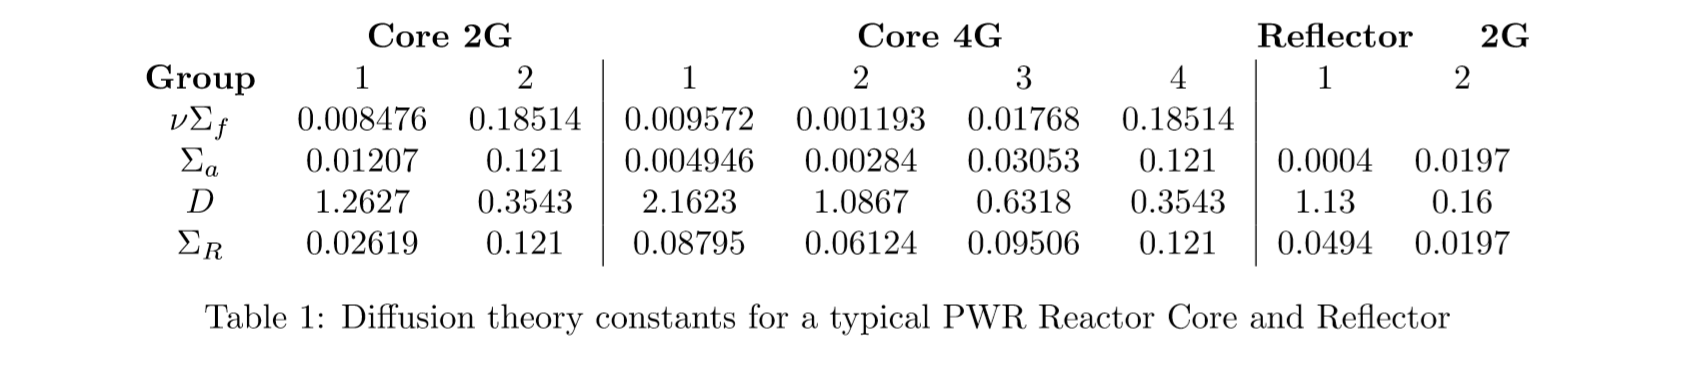

Other data: 
* Fast fission factor (over all energies) $\epsilon$ = 1.27
* Reference PWR diameter $y_0$ = 340 cm
* Reference PWR height $z_0$ = 370 cm

In [ ]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from sympy.plotting import plot

Given values of cross sections and geometry:

In [ ]:
y0 = 340 # cm
z0 = 370 # cm

# Problem data (C1 | C2 | R1 | R2) PWR
NuSigmaF = np.array([0.008476,0.18514,0,0])       #cm-1   
SigmaA = np.array([0.01207,0.1210,0.0004,0.0197]) #cm-1
SigmaR1 = np.array([0.02619,0.1210,0.0494,0.0197]) #cm-1

D = np.array([1.2627,0.3543,1.13,0.16]) # cm

SigmaS12 = SigmaR1 - SigmaA

Fast = 1.27

My assumptions are:
* Extrapolated length can be neglected, because of big dimensions of the reactor
* No upscattering from thermal to fast
* All fission neutrons emit in the fast group
* Effects of fast fission are taken into account with the fast fission factor $\epsilon$.

Since we have a 2D slab geometry, we can use the *transverse buckling* $B_T$ to take into account the effects of neutron leakage in the transverse direction:

\begin{equation}
  B_T^2 = \left(\frac{\pi}{y_0}\right)^2 + \left(\frac{\pi}{z_0}\right)^2
\end{equation}

where y$_0$ is the transverse dimension.


Based on the assumptions above, the equations to be solved are (note that G1 is the fast group, G2 is the thermal group):

\begin{cases}
\begin{aligned}
  -D_{1c}\frac{d^2\varphi_{1c}}{dx^2} + (\Sigma_{1ac}+\Sigma_{1\rightarrow 2c} + D_{1c}B_T^2)\varphi_{1c} = \epsilon\nu\Sigma_{f2}\varphi_{2c} \quad &\text{Core G1} \\
  -D_{2c}\frac{d^2\varphi_{2c}}{dx^2} + (\Sigma_{2ac} + D_{2c}B_T^2)\varphi_{2c} = \Sigma_{1\rightarrow 2c}\varphi_{1c} \quad &\text{Core G2} \\
  -D_{1r}\frac{d^2\varphi_{1r}}{dx^2} + (\Sigma_{1ar}+\Sigma_{1\rightarrow 2r} + D_{1r}B_T^2)\varphi_{1r} = 0 \quad &\text{Reflector G1} \\
  -D_{2r}\frac{d^2\varphi_{2r}}{dx^2} + (\Sigma_{2ar} + D_{2r}B_T^2)\varphi_{2r} = \Sigma_{1\rightarrow 2r}\varphi_{1r} \quad &\text{Reflector G2} \\
\end{aligned}
\end{cases}


In [ ]:
# Define the equations

x = sp.symbols('x', real = True)

DD = sp.symbols('D_1c D_2c D_1r D_2r', real = True, positive = True)
SA = sp.symbols('Sigma_1ac Sigma_2ac Sigma_1ar Sigma_2ar', positive = True)
SS = sp.symbols('Sigma_12c Sigma_12r', positive = True)
SF = sp.symbols('Sigma_2f', positive = True)

BT2 = sp.symbols('B_T^2', positive = True)
BT = sp.symbols('B_T', positive = True)
e = sp.symbols('epsilon', positive = True)

C1 = sp.Function('varphi_1c')
C2 = sp.Function('varphi_2c')
R1 = sp.Function('varphi_1r')
R2 = sp.Function('varphi_2r')

ODE = [
  sp.Eq(-DD[0]*C1(x).diff(x,2) + (SA[0]+SS[0]+DD[0]*BT2)*C1(x),e*SF*C2(x)),
  sp.Eq(-DD[1]*C2(x).diff(x,2) + (SA[1]+DD[1]*BT2)*C2(x),SS[0]*C1(x)),
  sp.Eq(-DD[2]*R1(x).diff(x,2) + (SA[2]+SS[1]+DD[2]*BT2)*R1(x),0),
  sp.Eq(-DD[3]*R2(x).diff(x,2) + (SA[3]+DD[3]*BT2)*R2(x),SS[1]*R1(x)),
]

ODE[0]

Eq(-D_1c*Derivative(varphi_1c(x), (x, 2)) + (B_T^2*D_1c + Sigma_12c + Sigma_1ac)*varphi_1c(x), Sigma_2f*epsilon*varphi_2c(x))

The boundary conditions are (with a as the half-width of the core, and neglecting the extrapolation length):
* $\frac{d\varphi_{1c}}{dx}\Big\vert_{x=0}$ = 0 (symmetry)
* $\frac{d\varphi_{2c}}{dx}\Big\vert_{x=0}$ = 0 (symmetry)
* $\varphi_{1c}(a) = \varphi_{1r}(a)$ (flux interface)
* $\varphi_{2c}(a) = \varphi_{2r}(a)$ (flux interface)
* $-D_{1c}\frac{d\varphi_{1c}}{dx}\Big\vert_{x=a} = -D_{1r}\frac{d\varphi_{1r}}{dx}\Big\vert_{x=a}$ (current interface)
* $-D_{2c}\frac{d\varphi_{2c}}{dx}\Big\vert_{x=a} = -D_{2r}\frac{d\varphi_{2r}}{dx}\Big\vert_{x=a}$ (current interface)
* $\lim_{x\rightarrow \infty}\varphi_{1r}(x)$ = 0 (boundedness)
* $\lim_{x\rightarrow \infty}\varphi_{2r}(x)$ = 0 (boundedness)

---

# Core region 
Start from the core region defining the following cross-sections:
\begin{aligned}
  \Sigma_{1c} &= \Sigma_{1ac}+\Sigma_{1\rightarrow 2c} + D_{1c}B_T^2 \\
  \Sigma_{2c} &= \Sigma_{2ac}+D_{2c}B_T^2
\end{aligned}

We use the concept of buckling:
\begin{aligned}
  \frac{d\varphi_{1c}}{dx^2} + B^2\varphi_{1c} = 0 \\
  \frac{d\varphi_{2c}}{dx^2} + B^2\varphi_{2c} = 0
\end{aligned}

So the steady-state core equations become:

\begin{aligned}
  D_{1c}B^2\varphi_{1c} + \Sigma_{1c}\varphi_{1c} - \epsilon\nu\Sigma_{f2}\varphi_{2c} = 0 \quad &\text{Core G1} \\
  D_{2c}B^2\varphi_{2c} + \Sigma_{2c}\varphi_{2c} - \Sigma_{1\rightarrow 2c}\varphi_{1c} = 0 \quad &\text{Core G2} \\
\end{aligned}

In matrix form:
\begin{equation}
\begin{bmatrix}
  D_{1c}B^2 + \Sigma_{1c} & -\epsilon\nu\Sigma_{f2} \\
  -\Sigma_{1\rightarrow 2c} & D_{2c}B^2 + \Sigma_{2c}
\end{bmatrix}\begin{bmatrix}
  \varphi_{1c} \\
  \varphi_{2c} \\
\end{bmatrix} = \begin{bmatrix} 0 \\ 0 \end{bmatrix}\end{equation}

The system has solutions if the determinant of the matrix is zero. This leads to two roots for $B^2$ that we call $\mu^2$ (positive) and $\lambda^2$ (negative), so there are two solutions:
\begin{aligned}
  \frac{dX^2}{dx^2} + \mu^2X = 0 \\
  \frac{dY}{dx^2} + \lambda^2Y= 0
\end{aligned}

And thus:
\begin{aligned}
  \varphi_{1c} = A_1 X(x) + B_1 Y(x) \\
  \varphi_{2c} = A_2 X(x) + B_2 Y(x)
\end{aligned}

In [ ]:
SC = sp.symbols('Sigma_1c Sigma_2c', positive = True)
B2 = sp.symbols('B^2', positive = True)
FC = sp.symbols('varphi_1c varphi_2c', nonnegative = True)

ODECore = [
  sp.Eq(DD[0]*B2*FC[0] + SC[0]*FC[0] - e*SF*FC[1],0),
  sp.Eq(DD[1]*B2*FC[1] + SC[1]*FC[1] - SS[0]*FC[0],0)
]

CoreMatrix = sp.linear_eq_to_matrix(ODECore,[FC[0],FC[1]])[0]

CoreDet = sp.Eq(sp.det(CoreMatrix),0)
CoreRoots = sp.solve(CoreDet,B2)

X = sp.Function('X')
Y = sp.Function('Y')
m2 = sp.symbols('mu^2', positive = True)
l2 = sp.symbols('lambda^2', negative = True)
m = sp.symbols('mu')
l = sp.symbols('lambda')

CoreG1 = [
  sp.Eq(X(x).diff(x,2) + m2*X(x),0),
  sp.Eq(Y(x).diff(x,2) - l2*Y(x),0)
]

CoreG1Sol = sp.dsolve(CoreG1)

CoreG1Sol = [
  CoreG1Sol[0].rhs.rewrite(sp.cos).subs(sp.sqrt(m2),m),
  CoreG1Sol[1].rhs.rewrite(sp.cos).subs(sp.sqrt(l2),l)
]

CoreG1Sol[1]

-C3*(-sinh(lambda*x) + cosh(lambda*x))/lambda + C4*(sinh(lambda*x) + cosh(lambda*x))/lambda

In [ ]:
BTrans = (np.pi/(y0))**2 + (np.pi/(z0))**2

SigmaC = np.array([
  SigmaA[0]+SigmaS12[0]+D[0]*BTrans,
  SigmaA[1]+D[1]*BTrans               
])

mu = CoreRoots[0].subs({
    DD[0]:D[0],
    DD[1]:D[1],
    SC[0]:SigmaC[0],
    SC[1]:SigmaC[1],
    e:Fast,
    SF:NuSigmaF[1],
    SS[0]:SigmaS12[0]
})

lam = CoreRoots[1].subs({
    DD[0]:D[0],
    DD[1]:D[1],
    SC[0]:SigmaC[0],
    SC[1]:SigmaC[1],
    e:Fast,
    SF:NuSigmaF[1],
    SS[0]:SigmaS12[0]
})

print("Transversal buckling (squared): " + str(BTrans))
print("Overall core cross sections: " + str(SigmaC[0]) + " (fast); " + str(SigmaC[1]) + " (thermal)")
print("First root value: " + str(mu))
print("Second root value: " + str(lam))


Transversal buckling (squared): 0.00015747073175398043
Overall core cross sections: 0.02638883829298575 (fast); 0.12105579188026043 (thermal)
First root value: 0.000771954624628785
Second root value: -0.363346651955820


The general solutions based on the above are:
\begin{aligned}
  X(x) &= C_1\cos(\mu x) + C_2\sin(\mu x) \\
  Y(x) &= C_3\cosh(\lambda x) + C_4\sinh(\lambda x)
\end{aligned}

Based on the symmetry boundary conditions since we are in the core, the terms $\sin$ and $\sinh$ must be zero, therefore:
\begin{aligned}
  X(x) &= C_1\cos(\mu x) \\
  Y(x) &= C_3\cosh(\lambda x)
\end{aligned}

Which by substituting:
\begin{aligned}
  \varphi_{1c} = A^\prime _1 \cos(\mu x) + B^\prime_1 \cosh(\lambda x) \\
  \varphi_{2c} = A^\prime_2 \cos(\mu x) + B^\prime_2 \cosh(\lambda x)
\end{aligned}


In [ ]:
C = sp.symbols('C1 C2 C3 C4 C5 C6')

CoreG1Sol = [
  CoreG1Sol[0].subs({C[0]:C[0]*m,C[1]:C[1]*m}),
  CoreG1Sol[1].subs({C[2]:C[2]*l,C[3]:C[3]*l}).expand()
]

CoreG1Sol[1] = CoreG1Sol[1].collect(sp.sinh(l*x)).collect(sp.cosh(l*x))
CoreG1Sol[1] = CoreG1Sol[1].subs({-C[2]+C[3]:C[4],C[2]+C[3]:C[5]})

CoreG1Sol = [
  CoreG1Sol[0].subs(C[0],0),
  CoreG1Sol[1].subs(C[5],0)             
]

A = sp.symbols('A_1 A_2')
B = sp.symbols('B_1 B_2')

CoreSol = [
  A[0]*CoreG1Sol[0]/C[1]+B[0]/C[4]*CoreG1Sol[1],
  A[1]*CoreG1Sol[0]/C[1]+B[1]/C[4]*CoreG1Sol[1],
]

phi_1c=sp.Function('phi_1c')
phi_2c=sp.Function('phi_2c')

Phi_1c_eq=sp.Eq(phi_1c(x), CoreSol[0])
Phi_2c_eq=sp.Eq(phi_2c(x), CoreSol[1])

print("The fast flux in core: ")
Phi_1c_eq

The fast flux in core: 


Eq(phi_1c(x), A_1*cos(mu*x) + B_1*cosh(lambda*x))

In [ ]:
print("The thermal flux in core: ")
Phi_2c_eq

The thermal flux in core: 


Eq(phi_2c(x), A_2*cos(mu*x) + B_2*cosh(lambda*x))

# Reflector region

Now consider the reflector region defining the following cross-sections:
\begin{aligned}
  \Sigma_{1r} &= \Sigma_{1ar}+\Sigma_{1\rightarrow 2r} + D_{1r}B_T^2 \\
  \Sigma_{2r} &= \Sigma_{2ar}+D_{2r}B_T^2
\end{aligned}

As the first group equation does not depend from the second group flux, we can solve it as a stand-alone equation:

\begin{equation}
  -D_{1r}\frac{d^2\varphi_{1r}}{dx^2} + \Sigma_{1r}\varphi_{1r} = 0 
\end{equation}

By defining $L^2_1 = D_{1r}/\Sigma_{1r}$:

\begin{equation}
  \frac{d^2\varphi_{1r}}{dx^2} - \frac{1}{L^2_{1}}\varphi_{1r} = 0 
\end{equation}

Which lead to the following solution:
\begin{equation}
\varphi_{1r} = E\exp\left(\frac{x}{L_1}\right) + F\exp\left(-\frac{x}{L_1}\right)
\end{equation}

Due to the boundary condition of flux boundedness, the positive exponential must be zero, so $E = 0$, and since we are considering only the positive half-plane of the domain, the coordinate is taken with the absolute value.

Instead of 1/L coefficient k will be used

In [ ]:
SR =sp.symbols('Sigma_1r Sigma_2r', positive = True)
KR2 = sp.symbols('K^2_1 K^2_2')
KR = sp.symbols('K_1 K_2')
F = sp.symbols('F_1 F_2')

ReG1ODE = ODE[2].subs({BT2*DD[2]+SS[1]+SA[2]:-KR2[0],DD[2]:-1})

ReG1Sol = sp.dsolve(ReG1ODE).subs(sp.sqrt(KR2[0]),KR[0])
ReG1Sol = ReG1Sol.subs({C[1]:0,C[0]:F[0],x:sp.Abs(x)})
print("Solution of fast flux in the reflector:")
ReG1Sol

Solution of fast flux in the reflector:


Eq(varphi_1r(Abs(x)), F_1*exp(-K_1*Abs(x)))

For the second group, the equation is:

\begin{equation}
  -D_{2r}\frac{d^2\varphi_{2r}}{dx^2} + \Sigma_{2r}\varphi_{2r} - \Sigma_{1\rightarrow 2r}\varphi_{1r} = 0
\end{equation}

By defining $L^2_2 = D_{2r}/\Sigma_{2r}$:

\begin{equation}
  \frac{d^2\varphi_{2r}}{dx^2} - \frac{1}{L^2_{2}}\varphi_{2r} - \frac{\Sigma_{1\rightarrow 2r}}{D_{2r}}\varphi_{1r} = 0
\end{equation}

Now, based on the group 1 solution, we assume that the solution for group 2 can be written as:

\begin{equation}
  \varphi_{2r}(x) = F^\prime \exp\left(-\frac{\vert x\vert}{L_1}\right) + G \exp\left(-\frac{\vert x\vert}{L_2}\right)
\end{equation}

Substituting this expression into the ODE:

\begin{aligned}
  &-\frac{F^\prime}{L^2_1}\exp\left(-\frac{\vert x\vert}{L_1}\right) - \frac{G}{L^2_2}\exp\left(-\frac{\vert x\vert}{L_2}\right) + \frac{1}{L^2_{2}}\left(F^\prime \exp\left(-\frac{\vert x\vert}{L_1}\right) + G \exp\left(-\frac{\vert x\vert}{L_2}\right)\right) + \frac{\Sigma_{1\rightarrow 2r}}{D_{2r}}F\exp\left(-\frac{\vert x\vert}{L_1}\right) = 0 \\
  &\left(-\frac{F^\prime}{L^2_1} + \frac{F^\prime}{L^2_{2}} + \frac{\Sigma_{1\rightarrow 2r}}{D_{2r}}F\right)\exp\left(-\frac{\vert x\vert}{L_1}\right) = 0
\end{aligned}

As one of the two terms is an exponential, this equation is satisfied only if the coefficient between brackets is zero:

\begin{equation}
  \left(-\frac{F^\prime}{L^2_1} + \frac{F^\prime}{L^2_{2}} + \frac{\Sigma_{1\rightarrow 2r}}{D_{2r}}F\right) = 0
\end{equation}


In [ ]:
G = sp.symbols('G_2')

ReG2ODE = ODE[3].subs({BT2*DD[3]+SA[3]:-KR2[1],SS[1]:-SS[1]/DD[3],DD[3]:-1})

ReG2Sol = sp.Eq(R2(x),ReG1Sol.rhs.subs(F[0],F[1])+ReG1Sol.rhs.subs({F[0]:G,KR[0]:KR[1]}))

ReG2Sub = ReG2ODE.subs({R2(x):ReG2Sol.rhs,R1(x):ReG1Sol.rhs,sp.Abs(x):x}).doit()
ReG2Sub = sp.Eq(ReG2Sub.lhs-ReG2Sub.rhs,0).simplify()
ReG2Sub = sp.Eq(ReG2Sub.lhs.collect(sp.exp(-x*KR[0])).collect(sp.exp(-x*KR[1])),0)
ReG2Sub = ReG2Sub.subs(sp.exp(-x*KR[1]),0)

ReG2Cond = ReG2Sub.subs(sp.exp(-x*KR[0]),1)
print("Relation of coefficients can be found from equation:")
ReG2Cond

Relation of coefficients can be found from equation:


Eq(-F_2*K^2_2 + F_2*K_1**2 + F_1*Sigma_12r/D_2r, 0)

In [ ]:
print("Coefficient F2 using F1:")
F2 = sp.solve(ReG2Cond, F[1])
F2

Coefficient F2 using F1:


[F_1*Sigma_12r/(D_2r*(K^2_2 - K_1**2))]

In [ ]:
ODECoupling = sp.Eq(DD[0]*Phi_1c_eq.rhs.diff(x,2) + SC[0]*Phi_1c_eq.rhs - e*SF*Phi_2c_eq.rhs,0).expand()
ODECoupling

Eq(-A_1*D_1c*mu**2*cos(mu*x) + A_1*Sigma_1c*cos(mu*x) - A_2*Sigma_2f*epsilon*cos(mu*x) + B_1*D_1c*lambda**2*cosh(lambda*x) + B_1*Sigma_1c*cosh(lambda*x) - B_2*Sigma_2f*epsilon*cosh(lambda*x), 0)

In [ ]:
Coupling_core1 = sp.collect(ODECoupling.lhs, sp.cos(m*x))
Coupling_core1

B_1*D_1c*lambda**2*cosh(lambda*x) + B_1*Sigma_1c*cosh(lambda*x) - B_2*Sigma_2f*epsilon*cosh(lambda*x) + (-A_1*D_1c*mu**2 + A_1*Sigma_1c - A_2*Sigma_2f*epsilon)*cos(mu*x)

In [ ]:
Coupling_core2 = sp.collect(Coupling_core1, sp.cosh(l*x))
Coupling_core2

(-A_1*D_1c*mu**2 + A_1*Sigma_1c - A_2*Sigma_2f*epsilon)*cos(mu*x) + (B_1*D_1c*lambda**2 + B_1*Sigma_1c - B_2*Sigma_2f*epsilon)*cosh(lambda*x)

In [ ]:
Coupling_core_eq1 = sp.Eq(Coupling_core2.subs({sp.cosh(l*x):0, x:0}),0)
Coupling_core_eq1 

Eq(-A_1*D_1c*mu**2 + A_1*Sigma_1c - A_2*Sigma_2f*epsilon, 0)

In [ ]:
Coupling_core_eq2 = sp.Eq(Coupling_core2.subs({sp.cos(m*x):0, x:0}),0)
Coupling_core_eq2 

Eq(B_1*D_1c*lambda**2 + B_1*Sigma_1c - B_2*Sigma_2f*epsilon, 0)

In [ ]:
print("Coefficient A2 using A1:")
S1c = sp.solve(Coupling_core_eq1, A[1])
S1c

Coefficient A2 using A1:


[A_1*(-D_1c*mu**2 + Sigma_1c)/(Sigma_2f*epsilon)]

In [ ]:
print("Coefficient B2 using B1:")
S2c = sp.solve(Coupling_core_eq2, B[1])
S2c

Coefficient B2 using B1:


[B_1*(D_1c*lambda**2 + Sigma_1c)/(Sigma_2f*epsilon)]

The solutions found so far are:

\begin{aligned}
   \varphi_{1c} &= A^\prime _1 \cos(\mu x) + B^\prime_1 \cosh(\lambda x) \\
  \varphi_{2c} &= A^\prime_2 \cos(\mu x) + B^\prime_2 \cosh(\lambda x) \\
  \varphi_{1r} &= F\exp\left(-\frac{\vert x\vert}{L_1}\right) \\
  \varphi_{2r}(x) &= F^\prime \exp\left(-\frac{\vert x\vert}{L_1}\right) + G \exp\left(-\frac{\vert x\vert}{L_2}\right)
\end{aligned}

So we have six unknown coefficients ($F$ and $F^\prime$ are related based on the relation found before). It figures that also the coefficients for the core flux are related. Proceeding like we did for the reflector, so we substitute the expression for $\varphi_2$ into the equation for core group 1:

\begin{aligned}
  D_{1c}(A^\prime _1\mu^2  \cos(\mu x) - B^\prime_1\lambda^2 \cosh(\lambda x)) + \Sigma_{1c}(A^\prime_1 \cos(\mu x) + B^\prime_1 \cosh(\lambda x)) = \epsilon\Sigma_{f}(A^\prime _2 \cos(\mu x) + B^\prime_2 \cosh(\lambda x)) \\
  \cos(\mu x)(D_{1c}A^\prime _1 \mu^2 + \Sigma_{1c}A^\prime _1 - \epsilon\Sigma_{f}A^\prime _2) + \cosh(\lambda x)(-D_{1c}B^\prime _1\lambda^2 +\Sigma_{1c}B^\prime_1 - \epsilon\Sigma_{f}B^\prime _2) = 0 
\end{aligned}

As the above equation needs to be valid for every x, we need to make the coefficients null:

\begin{aligned}
  D_{1c}A^\prime _1 \mu^2 + \Sigma_{1c}A^\prime _1 - \epsilon\Sigma_{f}A^\prime _2 = 0 \\
  -D_{1c}B^\prime _1\lambda^2 +\Sigma_{1c}B^\prime_1 - \epsilon\Sigma_{f}B^\prime _2 = 0
\end{aligned}

From the reflector condition and the above system we can determine the coupling coefficients of the system:

\begin{cases}
\begin{aligned}
  S_{1c} &= \frac{A^\prime _2}{A^\prime _1} = \frac {D_{1c}\mu^2 + \Sigma_{1c}}{\epsilon\Sigma_{f}}\\
  S_{2c} &= \frac{B^\prime _2}{B^\prime _1} = \frac {-D_{1c}\lambda^2 + \Sigma_{1c}}{\epsilon\Sigma_{f}} \\
  S_{1r} &= \frac{F^\prime}{F} = \frac{\Sigma_{1\rightarrow 2r} / D_{2r}}{L_2^2 - L_1^2}
\end{aligned}
\end{cases}

So actually we have only four unknown coefficients as the coupling coefficients are known:
\begin{cases}
\begin{aligned}
   \varphi_{1c} &= \underline{A^\prime _1} \cos(\mu x) + \underline{B^\prime_1} \cosh(\lambda x) \\
  \varphi_{2c} &= S_{1c}\underline{A^\prime _1} \cos(\mu x) + S_{2c}\underline{B^\prime_1} \cosh(\lambda x) \\
  \varphi_{1r} &= \underline{F}\exp\left(-\frac{\vert x\vert}{L_1}\right) \\
  \varphi_{2r}(x) &= S_{1r}\underline{F}\exp\left(-\frac{\vert x\vert}{L_1}\right) + \underline{G} \exp\left(-\frac{\vert x\vert}{L_2}\right)
\end{aligned}
\end{cases}

In [ ]:
S = sp.symbols('S_1c S_2c S_1r')

ODESol = [
 CoreSol[0],
 CoreSol[1].subs({A[1]:S[0]*A[0],B[1]:S[1]*B[0]}),
 ReG1Sol.rhs,
 ReG2Sol.rhs.subs(F[1],S[2]*F[0])
]

By applying the four remaining BCs (those at the interface) we can determine the unknown coefficients (for brevity we call them $[A,B,F,G]$):

\begin{aligned}
A\cos(\mu a) + B\cosh(\lambda a)  = F\exp\left(-\frac{a}{L_1}\right) &\quad \text{Flux interface 1G} \\
S_{1c}A\cos(\mu a) + S_{2c}B\cosh(\lambda a) = S_{1r}F\exp\left(-\frac{a}{L_1}\right) + G\exp\left(-\frac{a}{L_2}\right) &\quad \text{Flux Interface 2G} \\
 D_{1c}A\mu \sin(\mu a) -D_{1c}B\lambda \sinh(\lambda a))
 = D_{1r}\frac{F}{L_1}\exp\left(-\frac{a}{L_1}\right) &\quad \text{Current Interface G1} \\
 D_{2c}S_{1c}A\mu \sin(\mu a) -D_{2c}S_{2c}B\lambda \sinh(\lambda a)) = D_{2r}\frac{S_{1r}F}{L_1}\exp\left(-\frac{a}{L_1}\right) + D_{2r}\frac{G}{L_2} \exp\left(-\frac{\vert x\vert}{L_2}\right) &\quad \text{Current Interface 2G}
\end{aligned}

Writing this system into matrix form and then computing the matrix determinant gives us an equation in which the only unknown is the half-width critical thickness $a$:

\begin{equation}
\begin{bmatrix}
  \cos(\mu a) & \cosh(\lambda a) & -\exp\left(-\frac{a}{L_1}\right) & 0 \\
  S_{1c}\cos(\mu a) & S_{2c}\cosh(\lambda a) & -S_{1r}\exp\left(-\frac{a}{L_1}\right) & -\exp\left(-\frac{a}{L_2}\right) \\
  D_{1c}\mu \sin(\mu a) & - D_{1c}\lambda \sinh(\lambda a)) & -\frac{D_{1r}}{L_1}\exp\left(-\frac{a}{L_1}\right) & 0 \\
  D_{2c}S_{1c}\mu \sin(\mu a)) & -D_{2c}S_{2c}\lambda \sinh(\lambda a)) & -\frac{S_{1r}D_{2r}}{L_1}\exp\left(-\frac{a}{L_1}\right) & -\frac{D_{2r}}{L_2} \exp\left(-\frac{\vert x\vert}{L_2}\right)
\end{bmatrix}\begin{bmatrix}
  A \\
  B \\
  F \\
  G
\end{bmatrix} = \begin{bmatrix} 0 \\ 0 \end{bmatrix}\end{equation}

In [ ]:
a = sp.symbols('a')

ODEBC = [
 ODESol[0].subs(x,a)-ODESol[2].subs(sp.Abs(x),a),
 ODESol[1].subs(x,a)-ODESol[3].subs(sp.Abs(x),a),
 (DD[0]*ODESol[0].diff(x,1)-DD[2]*ODESol[2].subs(sp.Abs(x),x).diff(x,1)).subs(x,a),
 (DD[1]*ODESol[1].diff(x,1)-DD[3]*ODESol[3].subs(sp.Abs(x),x).diff(x,1)).subs(x,a)
]

BCMatrix = sp.linear_eq_to_matrix(ODEBC,[A[0],B[0],F[0],G])[0]

BCDet = sp.det(sp.trigsimp(BCMatrix))
BCMatrix

Matrix([
[              cos(a*mu),                  cosh(a*lambda),              -exp(-K_1*a),                    0],
[         S_1c*cos(a*mu),             S_2c*cosh(a*lambda),         -S_1r*exp(-K_1*a),         -exp(-K_2*a)],
[     -D_1c*mu*sin(a*mu),      D_1c*lambda*sinh(a*lambda),      D_1r*K_1*exp(-K_1*a),                    0],
[-D_2c*S_1c*mu*sin(a*mu), D_2c*S_2c*lambda*sinh(a*lambda), D_2r*K_1*S_1r*exp(-K_1*a), D_2r*K_2*exp(-K_2*a)]])

In [ ]:
Crit_eq  = sp.Eq(BCDet,0)
Crit_eq

Eq((D_1c*D_2c*S_1c*lambda*mu*sin(a*mu)*sinh(a*lambda) - D_1c*D_2c*S_2c*lambda*mu*sin(a*mu)*sinh(a*lambda) - D_1c*D_2r*K_1*S_1r*lambda*cos(a*mu)*sinh(a*lambda) - D_1c*D_2r*K_1*S_1r*mu*sin(a*mu)*cosh(a*lambda) - D_1c*D_2r*K_2*S_1c*lambda*cos(a*mu)*sinh(a*lambda) + D_1c*D_2r*K_2*S_1r*lambda*cos(a*mu)*sinh(a*lambda) + D_1c*D_2r*K_2*S_1r*mu*sin(a*mu)*cosh(a*lambda) - D_1c*D_2r*K_2*S_2c*mu*sin(a*mu)*cosh(a*lambda) + D_1r*D_2c*K_1*S_1c*mu*sin(a*mu)*cosh(a*lambda) + D_1r*D_2c*K_1*S_2c*lambda*cos(a*mu)*sinh(a*lambda) - D_1r*D_2r*K_1*K_2*S_1c*cos(a*mu)*cosh(a*lambda) + D_1r*D_2r*K_1*K_2*S_2c*cos(a*mu)*cosh(a*lambda))*exp(-K_1*a)*exp(-K_2*a), 0)

In [ ]:
# Substituting symbols by numbers

SigmaR = np.array([
  SigmaA[2]+SigmaS12[2]+D[2]*BTrans,
  SigmaA[3]+D[3]*BTrans               
])

K2 = np.array([
  SigmaR[0]/D[2],
  SigmaR[1]/D[3]
])

SCoup = np.array([
 (D[0]*mu+SigmaC[0])/(Fast*NuSigmaF[1]),
 (-D[0]*(-lam)+SigmaC[0])/(Fast*NuSigmaF[1]), 
 (SigmaS12[2]/D[3])/(K2[1]-K2[0])
])

DetEquation = Crit_eq.subs({
  DD[0]:D[0],
  DD[1]:D[1],
  DD[2]:D[2],
  DD[3]:D[3],
  KR[0]:np.sqrt(K2[0]),
  KR[1]:np.sqrt(K2[1]),
  S[0]:SCoup[0],
  S[1]:SCoup[1],
  S[2]:SCoup[2],
  l:np.sqrt(float(-lam)),
  m:np.sqrt(float(mu))
})
DetEquation

Eq((0.014650986664464*sin(0.0277840714192284*a)*sinh(0.602782425055525*a) + 0.00696232717593798*sin(0.0277840714192284*a)*cosh(0.602782425055525*a) - 0.0314078207902674*cos(0.0277840714192284*a)*sinh(0.602782425055525*a) - 0.0260011878313812*cos(0.0277840714192284*a)*cosh(0.602782425055525*a))*exp(-0.560577929642501*a), 0)

Overall reflector cross sections: 0.049577941926881995 (fast); 0.019725195317080637 (thermal)
Reflector diffusion length (squared): 22.79239428023322 (fast); 8.111453267154785 (thermal)
Coupling coefficients: [0.116377499374827 -1.83903808538007 3.856655290102389]
The core critical width is: 87.28728728728728
The core critical half-width is: 43.64364364364364


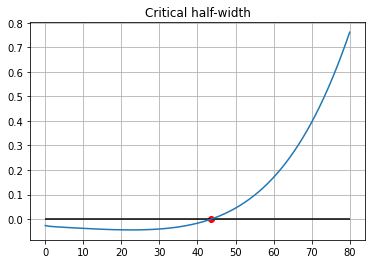

In [ ]:
Criticality = sp.lambdify(a,DetEquation.lhs)

Trial = np.linspace(0,80,1000)

RootID = np.where(Criticality(Trial)>0) #For PWR
Root = Trial[RootID[0][0]]

plt.title('Critical half-width')
plt.plot(Trial,Criticality(Trial))
plt.hlines(0,Trial[0],Trial[-1])
plt.scatter(Root,0,color = 'red')
plt.grid()

print("Overall reflector cross sections: " + str(SigmaR[0]) + " (fast); " + str(SigmaR[1]) + " (thermal)")
print("Reflector diffusion length (squared): " + str(1/K2[0]) + " (fast); " + str(1/K2[1]) + " (thermal)")
print("Coupling coefficients: " + str(SCoup))
print("The core critical width is: " + str((Root)*2))
print("The core critical half-width is: "+ str(Root))

Having found the critical width, now we can compute the coefficients and determine the flux for the two region. As the system is critical, the flux level is arbitrary, so only three constants can be determined. Here we choose A = 1 to simulate a normalised initial fast source.

In [ ]:
BCCond = [
  ODEBC[0].subs({
      a:Root,
      m:np.sqrt(float(mu)),
      l:np.sqrt(float(-lam)),
      KR[0]:np.sqrt(K2[0]),
      A[0]:1
  }),
  ODEBC[1].subs({
      DD[0]:D[0],
      DD[2]:D[2],
      a:Root,
      m:np.sqrt(float(mu)),
      l:np.sqrt(float(-lam)),
      KR[0]:np.sqrt(K2[0]),
      KR[1]:np.sqrt(K2[1]),
      A[0]:1,
      S[0]:SCoup[0],
      S[1]:SCoup[1],
      S[2]:SCoup[2]
  }),
  ODEBC[2].subs({
      DD[0]:D[0],
      DD[2]:D[2],
      a:Root,
      S[0]:SCoup[0],
      S[1]:SCoup[1],
      S[2]:SCoup[2],
      m:np.sqrt(float(mu)),
      l:np.sqrt(float(-lam)),
      KR[0]:np.sqrt(K2[0]),
      KR[1]:np.sqrt(K2[1]),
      A[0]:1, 
      DD[1]:D[1],
      DD[3]:D[3]     
  }),
  ODEBC[3].subs({
      DD[1]:D[1],
      DD[3]:D[3],
      a:Root,
      S[0]:SCoup[0],
      S[1]:SCoup[1],
      S[2]:SCoup[2],
      m:np.sqrt(float(mu)),
      l:np.sqrt(float(-lam)),
      KR[0]:np.sqrt(K2[0]),
      KR[1]:np.sqrt(K2[1]),
      A[0]:1
  })
]

BCEq = [
  sp.Eq(BCCond[0],0),
  sp.Eq(BCCond[1],0),
  sp.Eq(BCCond[2],0),
  sp.Eq(BCCond[3],0),
]
BCEq

[Eq(133114323777.114*B_1 - 0.000107107212053578*F_1 + 0.350587377329472, 0),
 Eq(-244802311135.727*B_1 - 0.000413075595974552*F_1 - 2.21247654893291e-7*G_2 + 0.040800482285983, 0),
 Eq(101317753601.173*B_1 + 2.53514137900406e-5*F_1 - 0.0328562332718852, 0),
 Eq(-52281404650.2489*B_1 + 1.38437754484863e-5*F_1 + 1.24293759294367e-8*G_2 - 0.00107289634625695, 0)]

In [ ]:
B1_eval = sp.solve(BCEq[1],B[0])[0]
B1_eval

-1.68738437990289e-15*F_1 - 9.03780907405827e-19*G_2 + 1.66667063299748e-13

In [ ]:
F1_eval = sp.solve(BCEq[0].subs(B[0], B1_eval), F[0])[0]
F1_eval

1123.75084553114 - 0.000362671442649048*G_2

In [ ]:
B1_evalf = B1_eval.subs(F[0], F1_eval)
B1_evalf

-2.91814780042979e-19*G_2 - 1.72953256035216e-12

In [ ]:
G2_eval = sp.solve(BCEq[3].subs({B[0]:B1_evalf, F[0]: F1_eval}), G)[0]
G2_eval

-4628541.44531309

In [ ]:
B1_evaluated = B1_evalf.subs(G, G2_eval)
F1_evaluated = F1_eval.subs(G, G2_eval)

Coeffs = [B1_evaluated,F1_evaluated,G2_eval]
print("Solution coefficients: " + str(Coeffs))

Solution coefficients: [-3.78855756568309e-13, 2802.39064886375, -4628541.44531309]


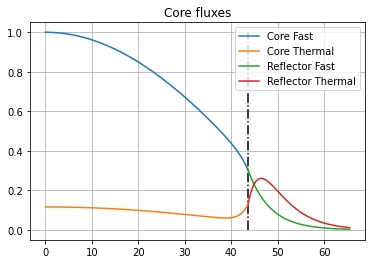

In [ ]:
NumSol = [
 ODESol[0].subs({
     A[0]:1,
     m:np.sqrt(float(mu)),
     B[0]:Coeffs[0],
     l:np.sqrt(float(-lam))
 }),
 ODESol[1].subs({
     A[0]:1,
     S[0]:SCoup[0],
     m:np.sqrt(float(mu)),
     B[0]:Coeffs[0],
     S[1]:SCoup[1],
     l:np.sqrt(float(-lam))
 }),
 ODESol[2].subs({
     F[0]:Coeffs[1],
     KR[0]:np.sqrt(K2[0]),
     sp.Abs(x):x
 }),
 ODESol[3].subs({
     F[0]:Coeffs[1],
     S[2]:SCoup[2],
     KR[0]:np.sqrt(K2[0]),
     G:Coeffs[2],
     KR[1]:np.sqrt(K2[1]),
     sp.Abs(x):x
 }),
]

Core1G = sp.lambdify(x,NumSol[0])
Core2G = sp.lambdify(x,NumSol[1])
Re1G = sp.lambdify(x,NumSol[2])
Re2G = sp.lambdify(x,NumSol[3])

xCore = np.linspace(0,Root,10000)
xRe = np.linspace(Root,Root+Root/2,10000)

plt.title('Core fluxes')
plt.vlines(Root,0,1,linestyle = '-.')
plt.plot(xCore,Core1G(xCore),label = 'Core Fast')
plt.plot(xCore,Core2G(xCore),label = 'Core Thermal')
plt.plot(xRe,Re1G(xRe), label = 'Reflector Fast')
plt.plot(xRe,Re2G(xRe), label = 'Reflector Thermal')
plt.grid()
plt.legend()